## Jax GPU Memory management

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import scalar 
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util
from kpsn.models import pose
from kpsn.util import pca
from kpsn.util import keypt_io
from kpsn.util import alignment

import kpsn_test.visualize as viz

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from jax import config
config.update("jax_debug_nans", True)

### Load data

In [5]:
metadata, keypts = keypt_io.npy_dataset("/n/groups/datta/kai/mph/data_explore/data/")

# operate on a subset of the data without some redundancy
# since we don't care about dynamics anyway
keypts = keypt_io.subsample_time(keypts, 15)

# rotate subject to standard orientation
align_result = alignment.sagittal_align(keypts)
metadata, align_result = keypt_io.select_subset(metadata, align_result, [
    i_subj for i_subj in range(len(align_result))
    if (not metadata['age'][i_subj] in [9, 12])
])

gt_obs = pose.Observations(
    keypt_io.to_feats(util.computations.restack(align_result))[:, :],
    util.computations.stack_ixs(align_result))

### Set up model

In [21]:
N = len(align_result)
M = gt_obs.keypts.shape[1]
eps = 0.05
morph_hyperparams = afm.AffineModeMorphHyperparams(
    N = N, M = M, L = 1,
    modes=None, update_scale = 0.3)
pose_hyperparams = gmm.GMMHyperparams(
    N = N, M = M, L = 5, eps = eps,
    pop_weight_uniformity = 10,
    subj_weight_uniformity = 100)
model = joint_model.JointModel(morph = afm.AffineModeMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

In [26]:
init_params = joint_model.init(
    model,
    hyperparams,
    gt_obs,
    reference_subject = 0,
    posespace_kws = dict(
        fit_to_all_subj = False,
        subsample = 0.1)
)

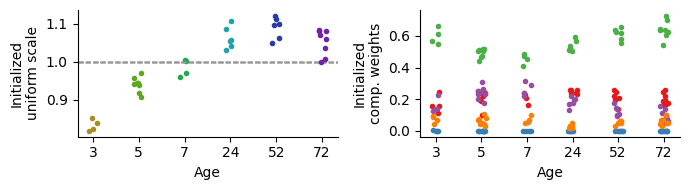

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (7, 2))

jitter = 0.1
ages, age_groups = keypt_io.get_groups(metadata, 'age')
age_pal = dict(zip(ages, sns.hls_palette(l = 0.4, n_colors = len(ages) + 2)[1:-1]))
comp_pal = sns.color_palette('Set1', hyperparams.posespace.L)

for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    ax[0].axhline(1, ls = '--', color = '.6', lw = 1)
    ax[0].plot(
        np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
        jnp.exp(init_params.morph.uniform_scale()[age_group]),
        'o', ms = 3, color = age_pal[age])
    for i_comp in range(hyperparams.posespace.L):
        ax[1].plot(
            np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
            init_params.posespace.weights()[age_group, i_comp],
            'o', ms = 3, color = comp_pal[i_comp],
        )

for i in [0,1]: 
    ax[i].set_xticks(np.arange(len(ages)))
    ax[i].set_xticklabels(ages)
    ax[i].set_xlabel("Age")
ax[0].set_ylabel("Initialized\nuniform scale")
ax[1].set_ylabel("Initialized\ncomp. weights")
sns.despine()
plt.tight_layout()
plt.show()